# Assess whether the model is spun up

In [1]:
import matplotlib.pyplot as plt
import netCDF4 as nc
import numpy as np
import matplotlib

%matplotlib inline

##### Parameters:

In [3]:
imin, imax = 1479, 2179
jmin, jmax = 159, 799

isize = imax - imin
jsize = jmax - jmin

year  = 2002
month = 8

stn_i = np.array([104-1, 100, 91, 175, 175, 233, 214, 352, 242, 458, 508, 547, 629])
stn_j = np.array([370, 365, 353, 311, 326, 313, 281, 281, 364, 332, 384, 457, 471])

In [33]:
initial   = '/data/brogalla/IC/Mn_ini_20210810.nc'
# folder    = '/data/brogalla/run_storage/Mn-reference-202110/'
# subfolder = 'ANHA12_ref-' 
# end       = '_20211012/' 
# folder    = '/data/brogalla/run_storage/Mn-bio-202110/'
# subfolder = 'ANHA12_bio-' 
# end       = '_20211022/' 
# folder    = '/data/brogalla/run_storage/Mn-clean-ice-202110/'
# subfolder = 'ANHA12_clean-ice-' 
# end       = '_20211023/' 
folder    = '/data/brogalla/run_storage/Mn-spm-202110/'
subfolder = 'ANHA12_spm-' 
end       = '_20211026/' 
end_yr1 = f'{folder}{subfolder}spin-up0{end}ANHA12_EXH006_2002_monthly.nc'
end_yr2 = f'{folder}{subfolder}spin-up1{end}ANHA12_EXH006_2002_monthly.nc'
end_yr3 = f'{folder}{subfolder}spin-up2{end}ANHA12_EXH006_2002_monthly.nc'
end_yr4 = f'{folder}{subfolder}spin-up3{end}ANHA12_EXH006_2002_monthly.nc'

file_list = [end_yr1, end_yr2, end_yr3, end_yr4]

In [34]:
colors = ['#f9ddd8', '#f2ac9f', '#ea7a65', '#e5593f', '#a03e2c', \
          '#e0dfea', '#b1b0cc', '#646199', '#46436b', \
          '#3d6977', '#5b9db3', '#84bfd2', '#c1dfe8'] # CB

name   = ['CAA1', 'CAA2', 'CAA3', 'CAA4', 'CAA5', 'CAA6', 'CAA7', 'CAA8', 'CAA9', \
          'CB1', 'CB2', 'CB3', 'CB4']

##### Load files:

In [35]:
mask  = nc.Dataset('/ocean/brogalla/GEOTRACES/data/ANHA12/ANHA12_mesh1.nc')
tmask = np.array(mask.variables['tmask'])[:,:,:,:]

In [36]:
ref   = nc.Dataset('/ocean/brogalla/GEOTRACES/data/ANHA12/ANHA12-EXH006_y2015m01d05_gridT.nc',  'r')
depth = np.array(ref.variables['deptht'])

##### Calculations:

In [37]:
def load_file(file):
    
    mn_file    = nc.Dataset(f'{file}')
    mn_monthly = np.array(mn_file.variables['dissolmn'][:,0,:,:,:])
    
    return mn_monthly

The year-to-year change is calculated as the sum over all depths of the concentration at the observed stations, $stn$, for each month from one year compared to the previous year. 

$$ diff_{stn} = \sum^{50}_{z=0} | Mn_{stn}(z,month,yr) - Mn_{stn}(z,month,yr-1) | $$

In [38]:
mn_monthly = np.zeros((len(file_list),12,50,700,640))
difference = np.zeros((len(file_list)-1,len(stn_i),12))

for run, file in enumerate(file_list):
    mn_monthly[run,:,:,:,:] = load_file(file)
    
    if run > 0:
        difference[run-1,:,:] = np.array([np.sum(np.abs(mn_monthly[run,:,:,i,j]-mn_monthly[run-1,:,:,i,j]), axis=1) for i, j in zip(stn_i, stn_j)])

##### Figures:

In [39]:
def plot_spinup_change(nruns, savefig=False):

    months = range(12 +1, 12*nruns +1)
    years  = np.linspace(2, 1+nruns, (nruns-1)*12 + 1)[0:-1]

    fig, ax = plt.subplots(1, 1, figsize=(4.5, 3.74*0.75), dpi=300)
    
    differences = np.empty((len(name),(nruns-1)*12))
    for stn in range(0,len(name)):
        differences[stn,:] = np.reshape(difference[:,stn,:],((nruns-1)*12))
        ax.plot(years, differences[stn,:], c=colors[stn], label=name[stn], linewidth=1)
        ax.plot(years, differences[stn,:], '.', c=colors[stn], markersize=6)

    # Line for spread in values
    ax.plot(years, np.max(differences,axis=0)-np.min(differences,axis=0), '-k', linewidth=2.5, label='spread')

    ax.set_xlim([1.9, 2+nruns-1])
    ax.set_ylim([0, 5.e-8])
    ax.xaxis.set_ticks(np.linspace(2,2+nruns-1, (nruns-1)*2 + 1))
    ax.tick_params(axis='both', which='major', labelsize=6)
    ax.set_xlabel('Years of spin up', fontsize=6)
    ax.set_ylabel(r'Mn change w.r.t. previous year [mol L$^{-1}$]', fontsize=6)
    font = matplotlib.font_manager.FontProperties(size=6)
    ax.legend(loc=(0.80, 0.15), frameon=False, prop=font)

    if savefig:
        fig.savefig('/ocean/brogalla/GEOTRACES/figures/paper1-202110/S7-spin-up-spm.png', bbox_inches='tight', dpi=300)
        fig.savefig('/ocean/brogalla/GEOTRACES/figures/paper1-202110/S7-spin-up-spm.svg', bbox_inches='tight', dpi=300, \
                    format='svg')
    
    return

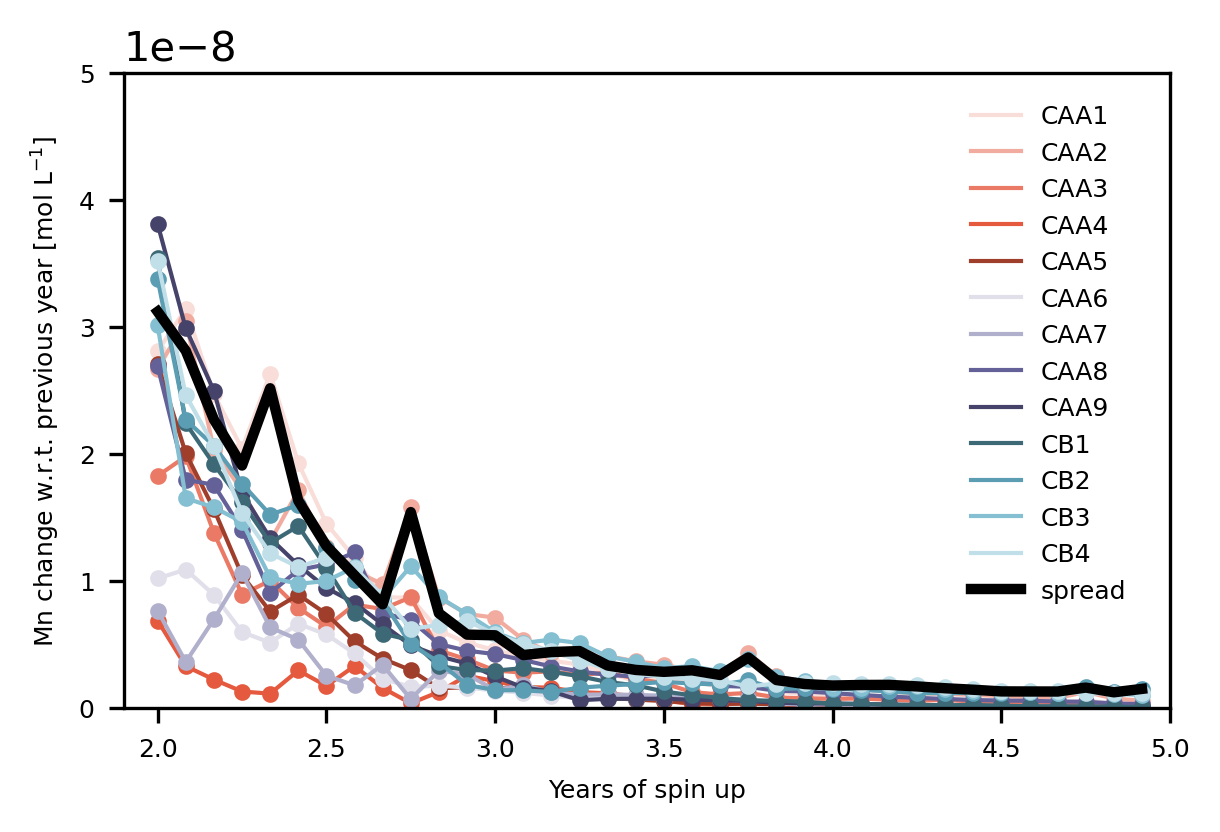

In [40]:
plot_spinup_change(4, savefig=True)